<a href="https://colab.research.google.com/github/ShutSV/data-science/blob/main/DS2_hw1__13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hw1 Применяя различные методы машинного обучения, оценить их производительность и провести анализ результатов
№13 Загрузить набор данных о населении городов и создайте модель регрессии для прогнозирования роста населения в будущем

Используются модули регресии:
- SVR
- Linear Regression
- Lasso Regression
- Ridge Regression
- ElasticNet Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost
- CatBoost
- AdaBoost
- KNeighborsRegressor


In [ ]:
!pip install catboost

In [3]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

Используются стат.данные от Eurostat о численности населения по группам возрастов для 878 городов ЕС

Описание https://ec.europa.eu/eurostat/cache/metadata/en/urb_esms.htm

Данные https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/urb_cpop1?format=TSV&compressed=true

Исходные данные требуют обработки, Data Preprocessing, тк содержат информацию по возрастным группам в виде
отдельных блоков строк, а не столбцов, и кроме городов также включена инф и в целом по странам, и не по всем временным периодам.

Предварительная обработка в Excel(Numbers): сохранен в формат CSV "estat_urb_cpop1.csv"

В файле 54647 строк, из которых первая строка заголовок, 54646 строк с данными

В файле 35 столбца. В первом столбце freq,indic_ur,cities\TIME_PERIOD - коды городов, имена переменных и групп населения, в столбцах 2-35 - годы с 1989 по 2022.

Индикаторы и переменные охватывают несколько аспектов качества жизни, например, демографию, жилье, здравоохранение,
экономическую активность, рынок труда, неравенство доходов, образовательную квалификацию, окружающую среду, климат, схемы путешествий, туризм и культурную инфраструктуру.

Расшифровка кодов переменных с DE1001V до DE1079V приведена в файле "variable_indicators.csv"

Отдельно сохранен файл CSV с кодами и названием городов "urb_esms_an_4.csv"

# Подготовка данных

получение списка городов по их кодам

In [5]:
import os
import pandas as pd

code_names = dict()
# попытка получить данные из файла CSV, с загрузкой в DataFrame
file_path = "urb_esms_an_4.csv"
if not os.path.exists(file_path):
    print("Такой файл не существует")
try:
    df_read = pd.read_csv(file_path,
                     header=0,
                     index_col=False,
                     sep=';')
    for index, row in df_read.iterrows():
        if row["CODE"][-1] == "C":
            # print(row["CODE"], row["NAME"])
            code_names[row["CODE"]] = row["NAME"]
except Exception as e:
    print("Ошибка чтения из файла", e)

print(code_names)

{'AT001C': 'Wien', 'AT002C': 'Graz', 'AT003C': 'Linz', 'AT004C': 'Salzburg', 'AT005C': 'Innsbruck', 'AT006C': 'Klagenfurt', 'BE001C': 'Bruxelles/Brussel', 'BE002C': 'Antwerpen', 'BE003C': 'Gent', 'BE004C': 'Charleroi', 'BE005C': 'Liège', 'BE006C': 'Brugge', 'BE007C': 'Namur', 'BE008C': 'Leuven', 'BE009C': 'Mons', 'BE010C': 'Kortrijk', 'BE011C': 'Oostende', 'BE012C': 'Mechelen', 'BE013C': 'Mouscron', 'BE014C': 'La Louvière', 'BE015C': 'Verviers', 'BG001C': 'Sofia', 'BG002C': 'Plovdiv', 'BG003C': 'Varna', 'BG004C': 'Burgas', 'BG005C': 'Pleven', 'BG006C': 'Ruse', 'BG007C': 'Vidin', 'BG008C': 'Stara Zagora', 'BG009C': 'Sliven', 'BG010C': 'Dobrich', 'BG011C': 'Shumen', 'BG012C': 'Pernik', 'BG013C': 'Yambol', 'BG014C': 'Haskovo', 'BG015C': 'Pazardzhik', 'BG016C': 'Blagoevgrad', 'BG017C': 'Veliko Tarnovo', 'BG018C': 'Vratsa', 'CH001C': 'Bern', 'CH002C': 'Zürich', 'CH003C': 'Genève', 'CH004C': 'Basel', 'CH005C': 'Lausanne', 'CH006C': 'Luzern', 'CH007C': 'Winterthur', 'CH008C': 'Lugano', 'CH009

проверка полноты данных об общей числености к просмотру, с заполнением отсутствующих значений нулями, и преобразованием текста в числа (int)

In [6]:
import csv
import re


# выборка строк, содержащих код DE1001V, т.е. полное население городов ЕС, и относящихся к городам из списка code_names
file_path = "estat_urb_cpop1.csv"
list_for_df = []
try:
    with open(file_path, "r") as file:
        content = csv.reader(file, skipinitialspace=True, delimiter=";")
        list_content = list(content)
except Exception as e:
    print("Ошибка чтения файла", e)


list_content[0][0] = "Cities"
list_for_df.append(list_content[0])
for i in list_content:
    if i[0][2:9] == "DE1001V" and i[0][10:] in code_names.keys():
        i[0] = code_names.get(i[0][10:])
        for j in range(1, len(i)):
            text = i[j]
            i[j] = re.sub(r'[^\d]', '', text)
            if i[j] == "":
                i[j] = 0
            else:
                i[j] = int(i[j])
        list_for_df.append(i)

df = pd.DataFrame(list_for_df[1:], columns=list_for_df[0])
print(df.describe())
print(df.info())
print(df.head(5))

               1989          1990          1991          1992          1993  \
count  8.780000e+02  8.780000e+02  8.780000e+02  8.780000e+02  8.780000e+02   
mean   1.123830e+04  3.753852e+04  7.402568e+04  9.018602e+04  5.744812e+04   
std    8.599381e+04  1.739367e+05  3.251034e+05  3.520810e+05  3.045616e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.655272e+06  3.120732e+06  6.829300e+06  6.822600e+06  6.831500e+06   

               1994          1995          1996          1997          1998  \
count  8.780000e+02  8.780000e+02  8.780000e+02  8.780000e+02  8.780000e+02   
mean   5.734395e+04  8.975493e+04  9.443750e+04  8.425317e+04  9.229601e+04   
std    3.043167e+05  3.510831e+05  3.547888e+05  3.

графический анализ входных данных на полноту

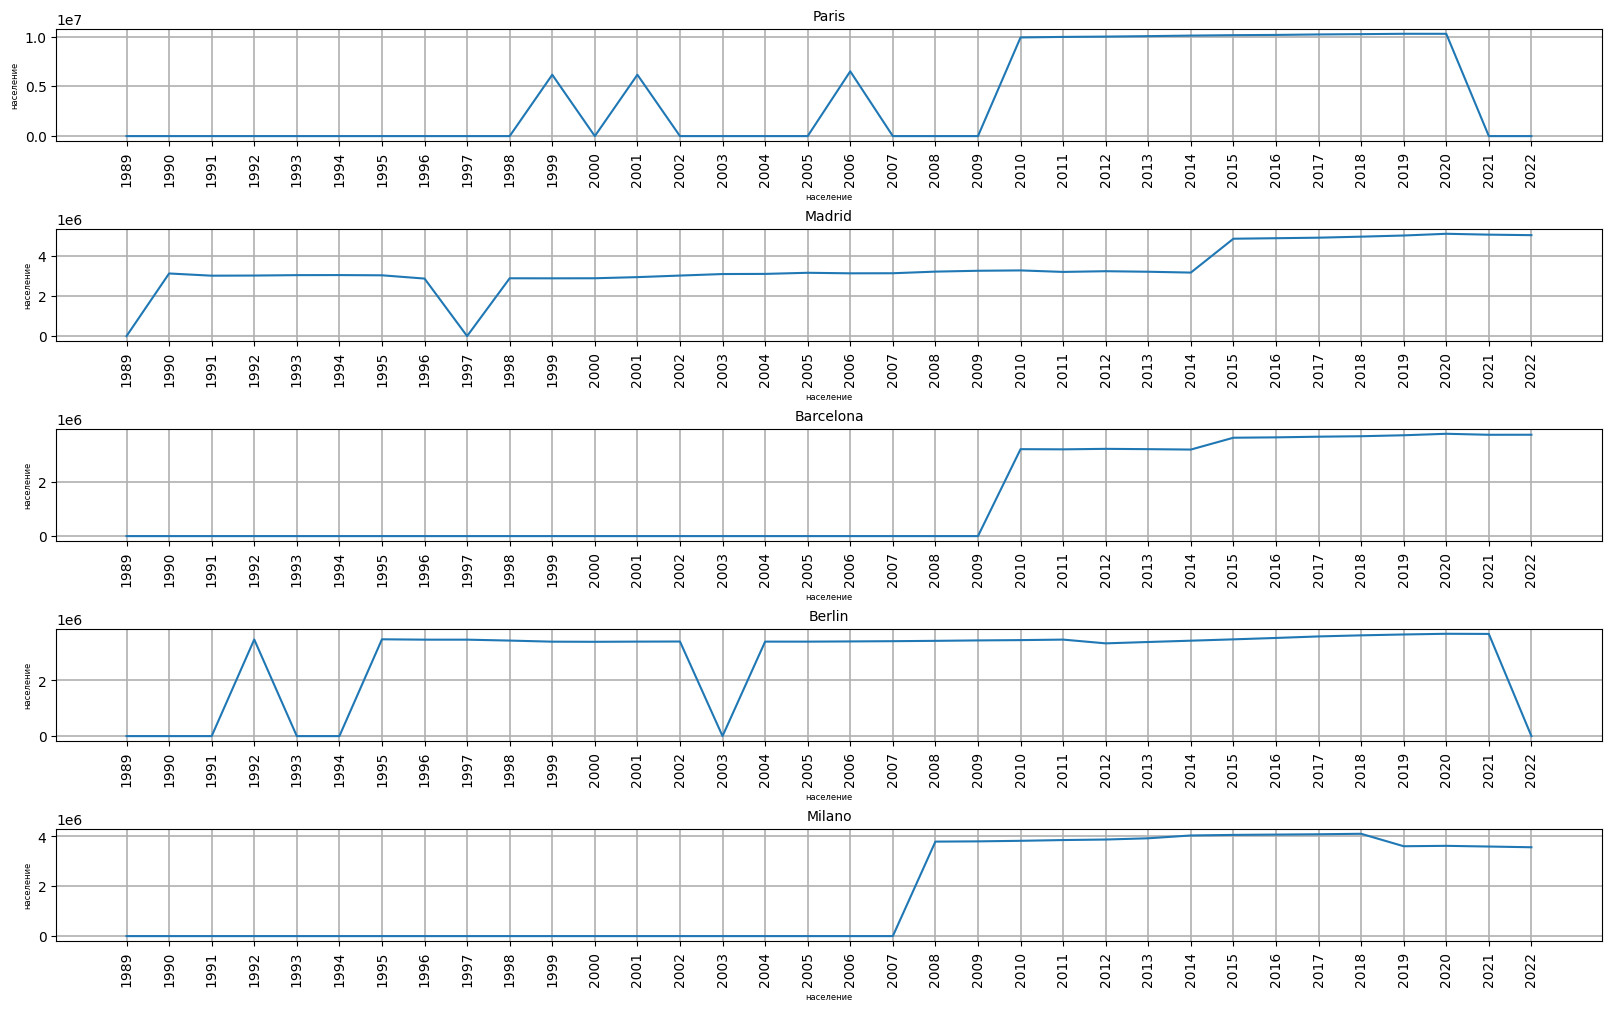

In [7]:
import matplotlib.pyplot as plt


# Используется датасет с полной численностью населения городов ЕС по годам
# Сортировка датасета по убыванию численности населения в 2019 году и вывод данных для крупнейших 5 городов
# Дата 2019 год принята тк это последний год, за который есть данные по многим городам
df_sort = df.sort_values(by="2019", ascending=False)
df_plot = df_sort.head(5)
x = df_plot.columns[1:]
label_x = "годы"
label_y = "население"

fig, axs = plt.subplots(5, 1, figsize=(16, 10), constrained_layout=True)
for i in range(5):
    axs[i].set_title(f"{df_plot.iloc[i, 0]}", fontsize=10)
    axs[i].set_ylabel(label_y, fontsize=6)
    axs[i].set_xlabel(label_y, fontsize=6)
    axs[i].grid(which="major", linewidth=1.2)
    axs[i].grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
    axs[i].plot(x, df_plot.iloc[i, 1:], label=f"")
    axs[i].xaxis.set_tick_params(rotation=90)

plt.show()

Как видно из графиков, не по всем городам достаточно ретроспективных данных.

Для изучения качественных показателй регрессионных моделей выбраны четыре города Испании, для которых имеются наиболее полные данные:
- ES005C Zaragoza,
- ES006C Málaga,
- ES007C Murcia,
- ES008C Las Palmas

Для первого города из выбранных создается датасет.
Для этого, из исходных данных извлекаются вск записи (строки) и формируется объект DataFrame, который затем транспонируется, чтобы получить в строках - временные периоды, а в столбцах - независимые переменные, т.е. данные, которые оказывают влияние на целевую переменную - общую численночть населения.

Этот показатель будет рвсполагаться в первом столбце датасета.

In [18]:
import csv
import re


file_path = "estat_urb_cpop1.csv"
try:
    with open(file_path, "r") as file:
        content = csv.reader(file, skipinitialspace=True, delimiter=";")
        list_content = list(content)
        list_content[0][0] = "Year"
except Exception as e:
    print("Ощибка чтения файла", e)


def df_cites(arg):
    df = []
    df.append(list_content[0])
    for i in list_content:
        if i[0][10:] == arg:
            for j in range(1, len(i)):
                text = i[j]
                i[j] = re.sub(r'[^\d]', '', text)
                if i[j] == "":
                    i[j] = 0
                else:
                    i[j] = int(i[j])
            df.append(i)
    df = pd.DataFrame(df[1:], columns=df[0])
    df = df.transpose()
    return df


df_zaragoza = df_cites("ES005C")
df_malaga = df_cites("ES006C")
df_murcia = df_cites("ES007C")
df_las_palmas = df_cites("ES008C")

# Визуализация полученного датасета
по городу Zaragoza

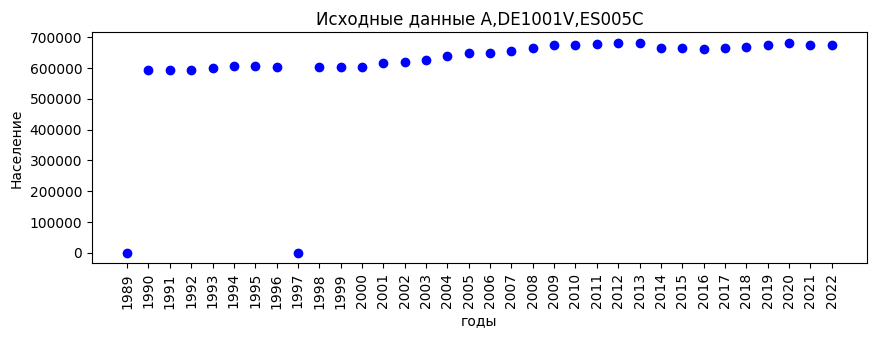

In [19]:
X = df_zaragoza.iloc[1:, 1:]
y = df_zaragoza.iloc[1:, 0]

plt.figure(figsize=(10, 3))
plt.scatter(y.index, y, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Исходные данные {df_zaragoza.iloc[0, 0]}")
plt.xticks(rotation=90)
plt.show()

На графике видно, что за 1989 и 1997 годы нет данных, поэтому их необходимо удалить

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Удаление строк с пропущенными значениями и заново определение X и y
df_zaragoza = df_zaragoza.drop(["1989", "1997"], axis=0)
X = df_zaragoza.iloc[1:, 1:]
y = df_zaragoza.iloc[1:, 0]

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Mean Squared Error (MSE): 889669590.2257864
R-squared (R2): 0.02244889711436937


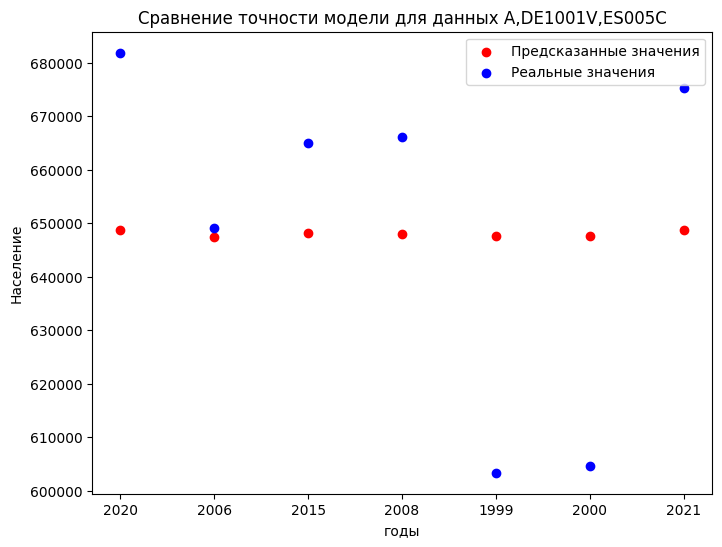

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Обучение модели регрессии (SVR)
model = SVR(kernel='linear', C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 203105697.3284232
R-squared (R2): 0.7768315331814739


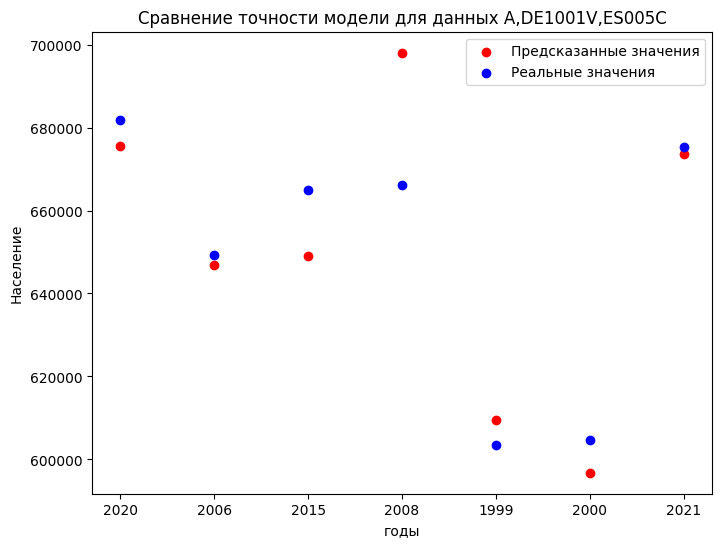

In [23]:
# Обучение модели регрессии (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.505e+08, tolerance: 2.639e+06
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 17472863.976346973
R-squared (R2): 0.9808011674915024


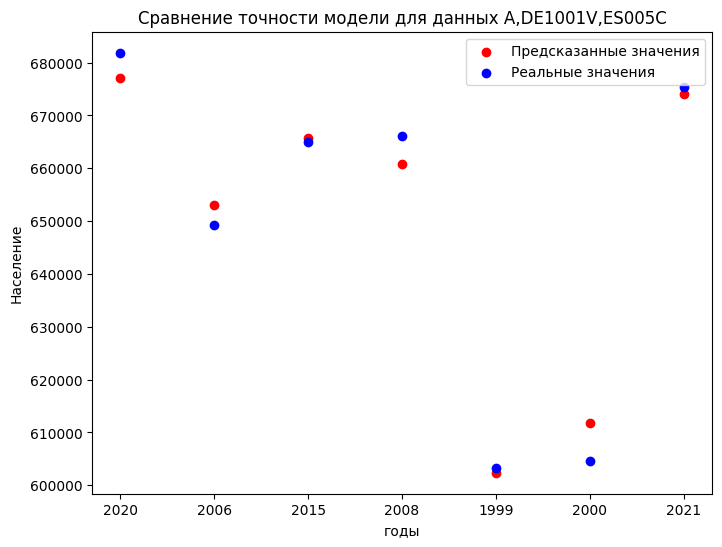

In [24]:
# Обучение модели регрессии (Lasso Regression)
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 67012678.948487364
R-squared (R2): 0.9263678123506622


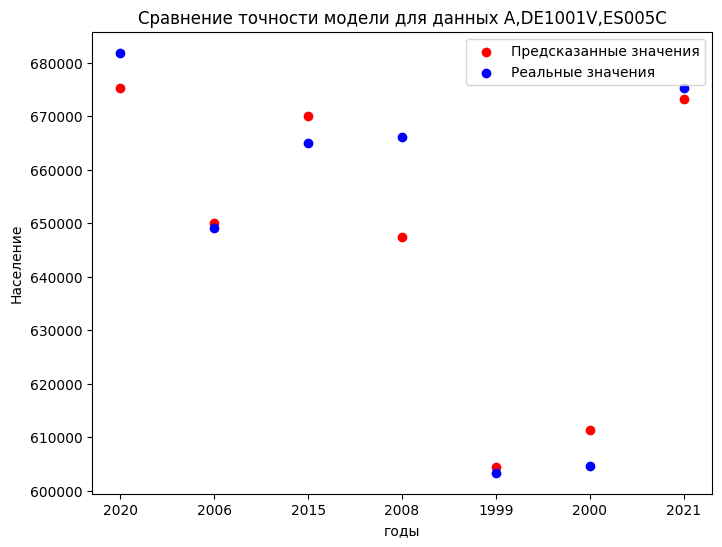

In [25]:
# Обучение модели регрессии (Ridge Regression)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+09, tolerance: 2.639e+06
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 69897118.97669242
R-squared (R2): 0.9231984474968363


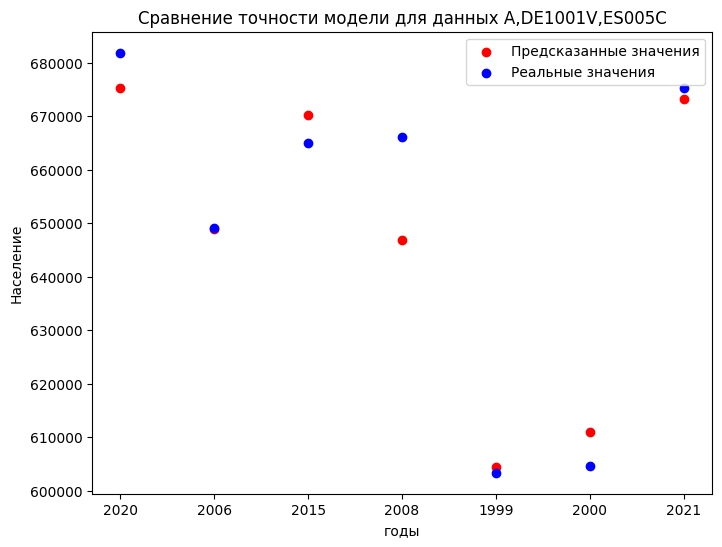

In [26]:
# Обучение модели регрессии (ElasticNet Regression)
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 28516057.95594832
R-squared (R2): 0.9686671274245607


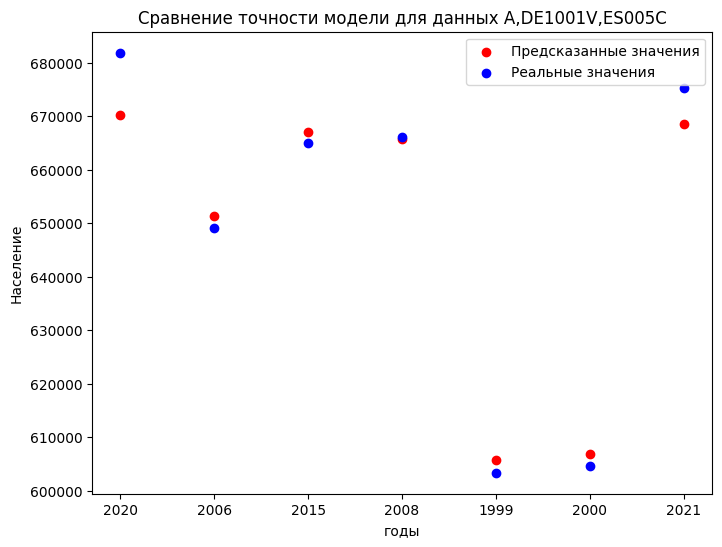

In [27]:
# Обучение модели регрессии (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 21851220.584196858
R-squared (R2): 0.9759903170613511


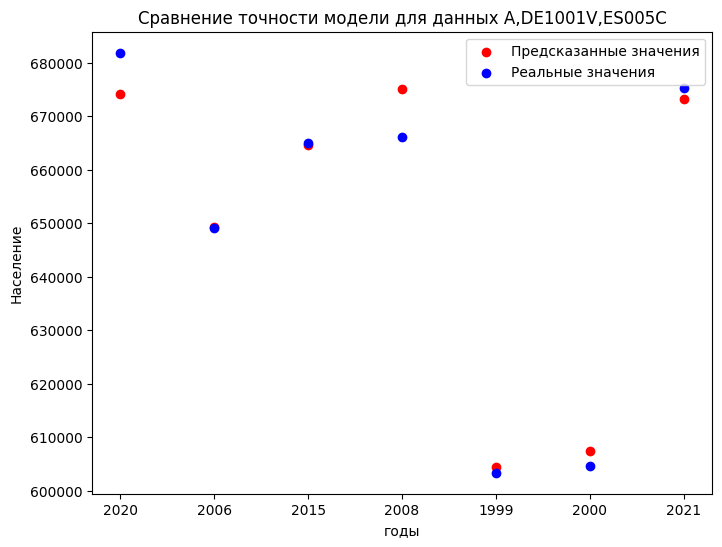

In [28]:
# Обучение модели регрессии (Gradient Boosting Regressor)
model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 21034859.00223214
R-squared (R2): 0.9768873187949954


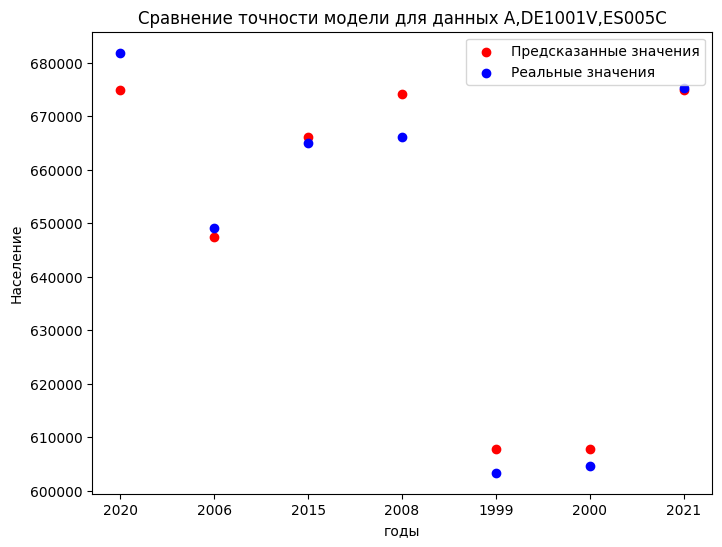

In [29]:
# Обучение модели регрессии (XGBoost)
model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Learning rate set to 0.148612
0:	learn: 30285.3122286	total: 47.3ms	remaining: 4.68s
1:	learn: 28581.7205854	total: 47.9ms	remaining: 2.35s
2:	learn: 25861.3704769	total: 48.3ms	remaining: 1.56s
3:	learn: 24416.3665526	total: 48.7ms	remaining: 1.17s
4:	learn: 22254.7168596	total: 49.5ms	remaining: 940ms
5:	learn: 21079.0813519	total: 50.2ms	remaining: 787ms
6:	learn: 19628.1409237	total: 51.2ms	remaining: 681ms
7:	learn: 18338.0135647	total: 52.2ms	remaining: 600ms
8:	learn: 17370.2790106	total: 53.2ms	remaining: 538ms
9:	learn: 16165.3321311	total: 53.8ms	remaining: 484ms
10:	learn: 15086.0219008	total: 54.4ms	remaining: 440ms
11:	learn: 14341.0143349	total: 55.2ms	remaining: 405ms
12:	learn: 13654.4281047	total: 56.2ms	remaining: 376ms
13:	learn: 13064.1334781	total: 57.2ms	remaining: 351ms
14:	learn: 12624.3965732	total: 58ms	remaining: 329ms
15:	learn: 12012.4867212	total: 59ms	remaining: 310ms
16:	learn: 11478.1771535	total: 60ms	remaining: 293ms
17:	learn: 11099.1371278	total: 60

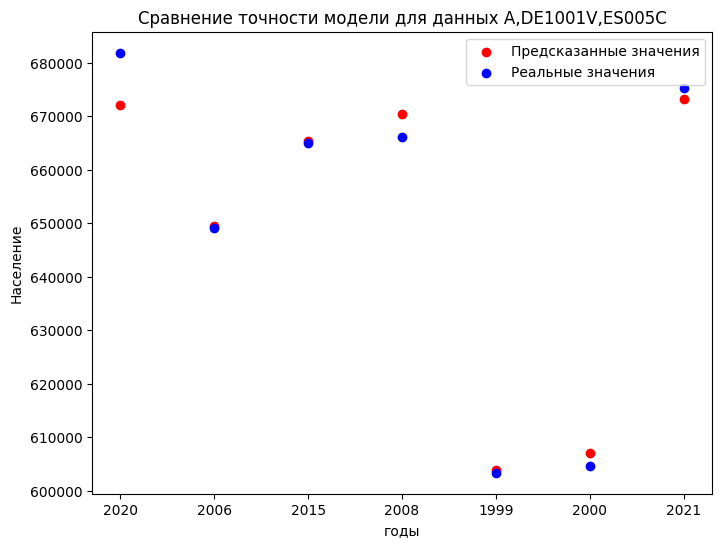

In [30]:
# Обучение модели регрессии (CatBoost)
model = CatBoostRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 25271286.07142857
R-squared (R2): 0.9722324176954349


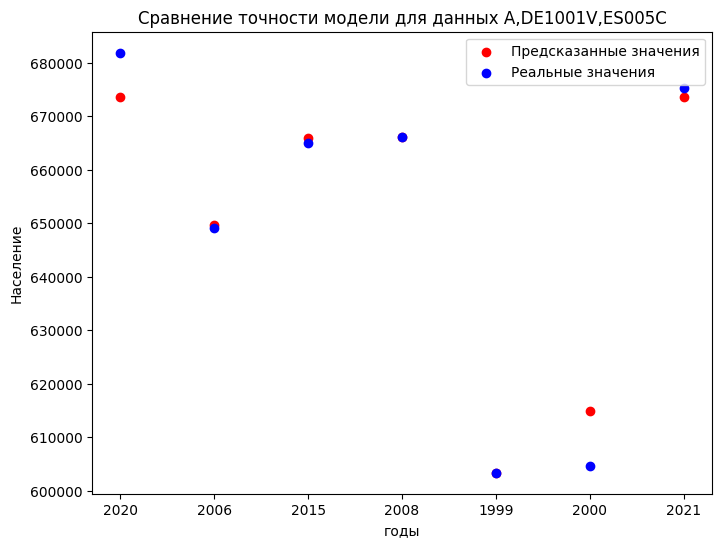

In [31]:
# Обучение модели регрессии (AdaBoost)
model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Mean Squared Error (MSE): 820484125.799999
R-squared (R2): 0.09846849786965528
Средняя абсолютная ошибка (MAE): 22780.37


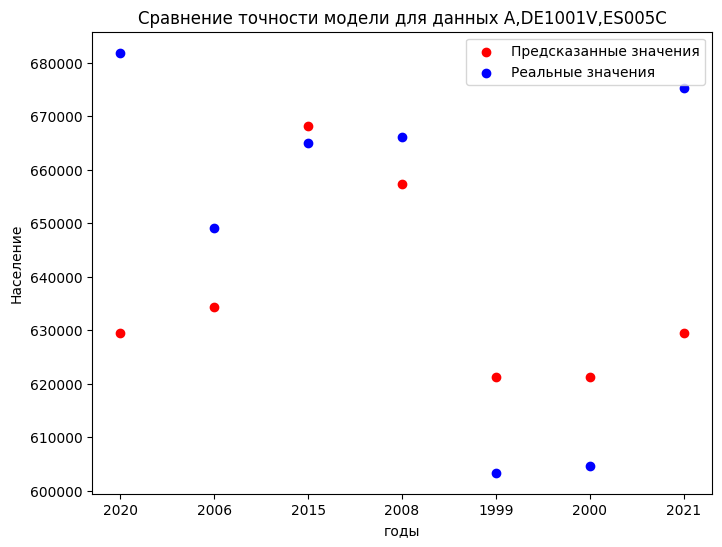

In [33]:
# Обучение модели регрессии (KNeighborsRegressor)
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))
# Оценка качества модели с помощью средней абсолютной ошибки (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
plt.figure(figsize=(8, 6))
plt.scatter(y_test.index, y_pred, c="r")
plt.scatter(y_test.index, y_test, c="b")
plt.xlabel("годы")
plt.ylabel("Население")
plt.title(f"Сравнение точности модели для данных {df_zaragoza.iloc[0, 0]}")
plt.legend(["Предсказанные значения", "Реальные значения"])
plt.show()

Полученные показатели качества регрессионных моделей на датасете df_zaragoza:


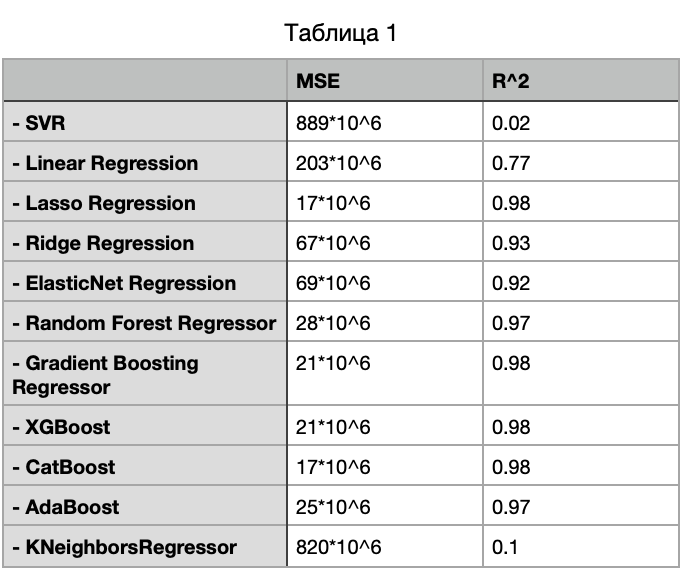

Среди обученных моделей лучшие показатели:
- CatBoost
- XGBoost
- Gradient Boosting Regressor
- Lasso Regression
- Random Forest Regressor

